## Model Building Seq-2-seq bidirectional with Attention

In [ ]:
# For the current version: 
!pip install -q tensorflow==2.0.0-beta1

In [2]:
# To determine which version you're using:
!pip show tensorflow

Name: tensorflow
Version: 2.0.0b1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tf-estimator-nightly, keras-preprocessing, google-pasta, protobuf, termcolor, absl-py, astor, tb-nightly, wrapt, keras-applications, numpy, grpcio, wheel, six, gast
Required-by: stable-baselines, magenta, fancyimpute


In [3]:
!pip3 install py-rouge

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
!pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.14.0-cp36-none-any.whl size=14746 sha256=8b23dcf184dfc18f4d8fabf0a4541f234e41f7301fab850c949e8697e2d5dfb4
  Stored in directory: /root/.cache/pip/wheels/e5/a0/7e/00e10c4ffdfd33f050c912d0f063a89fbb4ddd3788a56027fa
Successfully built keras-rectified-adam


In [6]:
#Mount google drive as your hardisk
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import rouge

In [2]:
# Path for GCP
PROJECT_PATH = './'
CORPUS_FILE_NAME = 'corpus_clean_dataframe_with_statistics.pkl'

In [3]:
# Path for Colab
#PROJECT_PATH = '/content/drive/My Drive/capstone/Abstractive_approach/'
#CORPUS_FILE_NAME = 'corpus_clean_dataframe_with_statistics.pkl'

In [4]:
#code snippet to import python modules
from os.path import join
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('utils', join(PROJECT_PATH, 'utils/utils.py')).load_module()

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


In [6]:
tf.executing_eagerly()

True

In [7]:
import nltk
import pandas as pd
import numpy as np
from utils import nice_print, rouge_scoring, score_distributions
import matplotlib.pyplot as plt
import re
import time
import pickle
from sklearn.model_selection import train_test_split

# Supporting functions

### Extract a dataset from CNN corpus

In [8]:
def extract_mini_dataset(corpus, first_n_to_print = None): 
  # Mini_dataset is a restricted sample of corpus
    mini_dataset = corpus.loc[(corpus.article_sentence_count >= ARTICLE_MIN_SENTENCES) &
                              (corpus.article_sentence_count <= ARTICLE_MAX_SENTENCES) &
                              (corpus.summary_sentence_count >= SUMMARY_MIN_SENTENCES) &
                              (corpus.summary_sentence_count <= SUMMARY_MAX_SENTENCES) &
                              (corpus.article_word_count <= MAX_WORD_ARTICLES) &
                              (corpus.summary_word_count <= MAX_WORD_SUMMARIES),
                              ['article','summary']]

    pattern_to_exclude = 'the daily transcript'
    index_to_drop = mini_dataset.loc[mini_dataset.summary.str.contains(pattern_to_exclude, flags=re.IGNORECASE) == True].index
    mini_dataset.drop(index_to_drop, axis = 0, inplace = True)
    N = min(N_EXAMPLES, len(mini_dataset))
    mini_dataset = mini_dataset.head(N)
    if first_n_to_print:
        for i in mini_dataset.index[:first_n_to_print]:
            nice_print(mini_dataset.loc[i,'article'], mini_dataset.loc[i,'summary'])
    return mini_dataset

### Preprocess data for seq2seq model

Including:
- Convert everything to lowercase
- Contraction mapping
- Remove (‘s)
- Remove parenthesis ( ), but keep text inside
- Insert space before punctuation
- Insert period to sentences missing punctuation
- Eliminate special characters

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
def preprocessing(text):

    s = text.lower()
    s = re.sub(r'[()]', '', s) # remove parenthesis
    s = re.sub(r'[\[\]]', '', s) # remove brackets
    s = re.sub('"','', s)     # remove double quotes  
    s = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in s.split(" ")])
    s = re.sub(r"'s\b","", s) # remove "'s"
    s = re.sub("'",'', s)     # remove single quotes  
    s = re.sub(r'([!?])\B', r' \1', s) # insert space before punctuation
    s = re.sub(r'([:,;]\B)', r' \1', s) # insert space before ending colon, semi-colon, semi-period
    s = re.sub(r'([^.::?!]\n)', r'\1.', s)# include period to mark end of sentence if missing punctuation
    s = ' '.join(treatment_of_period(i) for i in s.split()) # include space before periods, but cancel this action if the period is into an acronym or web address
    s = re.sub(r'\s+', r' ', s) # multiple spaces into 1 space
    

    return s

def treatment_of_period(word):
    result = word
    # check for acronyms
    if re.search('\w[.]+\w[.]+', word) != None:
      result = re.sub('[.]+', '', word)
      return result

    # check for URLs, web site address
    if re.match(r'(https?:\/\/)?([\w\d]+\.)?[\w\d]+\.\w+\/?.+', word) != None:
      if word[-1] == '.':
        result = word[:-1] + ' .'
        return result
      return word

    # check for single period or periods after word
    if word[-1] == '.':
      result = result = re.sub(r'[.]+', '', word)
      return result + ' .'

    return word


def preprocess_data(mini_dataset, first_n_to_print = None):  

    preprocessed = mini_dataset.copy()
    preprocessed.article = preprocessed.article.apply(preprocessing)
    preprocessed.summary = preprocessed.summary.apply(preprocessing)
    if first_n_to_print:
        for i in mini_dataset.index[:first_n_to_print]:
            print('ORIGINAL:')
            nice_print(mini_dataset.loc[i,'article'], mini_dataset.loc[i,'summary'])
            print('PREPROCESSED:')
            nice_print(preprocessed.loc[i,'article'], preprocessed.loc[i,'summary'])
    return preprocessed

In [11]:
def truncate(preprocessed):
      article_input = preprocessed.article.str.split() \
                                              .apply(lambda x: x[:MAX_WORD_ARTICLES - 1]) \
                                              .apply(lambda lst: ' '.join(lst))
      summary_input = preprocessed.summary.str.split() \
                                              .apply(lambda x: x[:MAX_WORD_SUMMARIES - 1]) \
                                              .apply(lambda lst: ' '.join(lst))
      preprocessed_truncated = pd.DataFrame(data =[[i,j] for (i,j) in zip(article_input, summary_input)], 
                                            columns = ['article', 'summary'], 
                                            index = preprocessed.index)
      return preprocessed_truncated

### Create dictionary for the data

In [12]:
def count_words(count_dict, text_list):
    '''Count the number of occurrences of each word in a list of text'''
    for text in text_list:
        for word in text.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [13]:
def unpack_glove(file_glove):
    t0 = time.time()
    embeddings_index = dict()
    f = open(PROJECT_PATH + file_glove)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        coefs = np.append(coefs, [0.0])
        embeddings_index[word] = coefs
    f.close()
    print('Glove uploading = {0:.2f} minutes'.format((time.time()-t0)/60))
    ## save embeddings on file
    f = open(PROJECT_PATH + 'glove_embeddings_100d.pkl','wb')
    pickle.dump(embeddings_index,f)
    f.close()

In [ ]:
embedding_index = 

In [14]:
def create_tokenizer(word_counts, embeddings_index):
    # Limit the vocab that we will use to words that are in GloVe

    #dictionary to convert words to integers
    vocab_to_int = {} 

    value = 0
    for word, count in word_counts.items():
        if word in embeddings_index and count > threshold:
            vocab_to_int[word] = value
            value += 1

    # Special tokens that will be added to our vocab
    codes = [START_DECODING, STOP_DECODING, OOV_DECODING, PAD_DECODING]
    # Add codes to vocab
    for code in codes:
        vocab_to_int[code] = len(vocab_to_int)

    # Dictionary to convert integers to words
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word

    usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

    print("Total number of unique words:", len(word_counts))
    print("Number of words we will use:", len(vocab_to_int))
    print("Percent of words we will use: {}%".format(usage_ratio))
    return vocab_to_int, int_to_vocab

In [36]:
def create_word_embedding_matrix(vocab_to_int, embeddings_index):

    nb_words = len(vocab_to_int)
    # Create matrix with default values of zero
    word_embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE), dtype=np.float32)
    for word, i in vocab_to_int.items():
        if word in embeddings_index:
            word_embedding_matrix[i] = embeddings_index[word][:-1]
        else:
            # If word not in CN, create a random embedding for it
            new_embedding = np.array(np.random.uniform(-1.0, 1.0, EMBEDDING_SIZE))
            embeddings_index[word] = new_embedding
            word_embedding_matrix[i] = new_embedding

    # Check if value matches len(vocab_to_int)
    print(len(word_embedding_matrix))
    return word_embedding_matrix

### Tokenize inputs and outputs

In [16]:
def convert_to_ints(text_list, max_token, start_token = False, stop_token = False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    word_count = 0
    unk_count = 0
    ints = []
   
    for text in text_list:
        text_int = []
        word_text = 0
        if start_token:
            text_int.append(vocab_to_int[START_DECODING])
            word_count += 1
            word_text += 1
        for word in text.split():
            word_count += 1
            word_text += 1
            if word_text >= max_token - 1*stop_token:
              break
            if word in vocab_to_int:
                text_int.append(vocab_to_int[word])
            else:
                text_int.append(vocab_to_int[OOV_DECODING])
                unk_count += 1
        
        if stop_token:
            text_int.append(vocab_to_int[STOP_DECODING])
        ints.append(text_int)
    return ints, word_count, unk_count

In [17]:
def padding(ints, max_token, stop_token = False):
  new_ints =[]
  for int in ints:
      len_int = len(int)
      if len_int < max_token:
              padding = [vocab_to_int[PAD_DECODING]]*(max_token-len_int)
              if stop_token:
                  int = int[:-1]
                  int.extend(padding)
                  int.append(vocab_to_int[STOP_DECODING])
              else:
                  int.extend(padding)
      new_ints.append(int)
  return new_ints

In [18]:
def split_datasets(input, output_in, output_out, fraction =0.1):
    # articles and summaries are truncated to their Maximum allowed sized
    input = np.array(input)
    output_in = np.array(output_in)
    output_out = np.array(output_out)
    val_len = int(len(input)*fraction)
    input_train = input[:-val_len]
    input_val = input[-val_len:]
    output_in_train = output_in[:-val_len]
    output_in_val = output_in[-val_len:]
    output_out_train = output_out[:-val_len]
    output_out_val = output_out[-val_len:]
    return input_train, input_val, output_in_train, output_in_val, output_out_train, output_out_val

In [48]:
def truncate_data_sequence(data_sequence, truncate_factor):
    original_length = len(data_sequence)
    truncated_length = int(original_length*truncate_factor)
    truncated = np.append(data_sequence[:truncated_length], [0.0]*(original_length -  truncated_length)).astype('int32')
    return truncated

### Model Building Seq-2-seq unidirectional

In [19]:
## Encoder subclass

class Encoder(tf.keras.Model):

  def __init__(self, 
               vocab_size, 
               embedding_size, 
               embedding_matrix, 
               lstm_size, 
               pre_trained_embeddings = False,
               trainable_embeddings = True,
               dropout_rate = 0.0):

      super(Encoder, self).__init__()

      #lstm_size contain the number of dimensions of the output
      self.lstm_size = lstm_size
      self.dropout_rate = dropout_rate
      #embedding with vocabulary size as input and dimension of embedding
      self.pre_trained_embeddings = pre_trained_embeddings
      if pre_trained_embeddings:
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                 embedding_size, 
                                                 weights=[embedding_matrix], 
                                                 trainable=trainable_embeddings) 
      else:
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                 embedding_size, 
                                                 trainable=trainable_embeddings) 

      # LSTM layer with 
      ## return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
      ## return_state: Boolean. Whether to return the last state in addition to the output
      #self.lstm_inner = tf.keras.layers.LSTM(
          #lstm_size, return_sequences=True, return_state= False)
      #self.lstm = tf.keras.layers.LSTM(
      #     lstm_size, return_sequences=True, return_state=True)
      self.backward_layer = tf.keras.layers.LSTM(lstm_size // 2, return_sequences=True, 
                                                return_state=True, go_backwards=True)
      self.forward_layer = tf.keras.layers.LSTM(lstm_size // 2, return_sequences=True, 
                                                return_state=True)
      
      self.bidirectional = tf.keras.layers.Bidirectional(layer = self.forward_layer, 
                                                         backward_layer= self.backward_layer, 
                                                         merge_mode = 'concat')
      self.dropout = tf.keras.layers.Dropout(rate = dropout_rate)
     

  def call(self, sequence, states, training_flag = False):
      embed = self.embedding(sequence)
      embed_dropout = self.dropout(embed, training = training_flag )
      outputs = self.bidirectional(embed_dropout, initial_state=states)
      #outputs = self.dropout(outputs, training = training_flag)
      output = outputs[0]
      state_f_h = outputs[1]
      state_f_c = outputs[2]
      state_b_h = outputs[3]
      state_b_c = outputs[4]
      state_h = tf.concat([state_f_h, state_b_h],-1)
      state_c = tf.concat([state_f_c, state_b_c],-1)     
      return output, state_h, state_c

  def init_states(self, batch_size):
 
      return [tf.zeros([batch_size, self.lstm_size // 2]),
              tf.zeros([batch_size, self.lstm_size // 2]),
              tf.zeros([batch_size, self.lstm_size // 2]),
              tf.zeros([batch_size, self.lstm_size // 2])]     

# Luong Attention subclass   

class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(rnn_size)

    def call(self, decoder_output, encoder_output):
        # Dot score: h_t (dot) Wa (dot) h_s
        # encoder_output shape: (batch_size, max_len, rnn_size)
        # decoder_output shape: (batch_size, 1, rnn_size)
        # score will have shape: (batch_size, 1, max_len)
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, encoder_output)

        return context, alignment

## Decoder subclass    

class Decoder(tf.keras.Model):

  def __init__(self, 
               vocab_size, 
               embedding_size, 
               embedding_matrix, 
               lstm_size, 
               pre_trained_embeddings = False,
               trainable_embeddings = True):

      super(Decoder, self).__init__()
      self.attention = LuongAttention(lstm_size)
      self.lstm_size = lstm_size
      self.pre_trained_embeddings = pre_trained_embeddings
      if pre_trained_embeddings:
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                 embedding_size, 
                                                 weights=[embedding_matrix], 
                                                 trainable=trainable_embeddings) 
      else:
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                 embedding_size, 
                                                 trainable=trainable_embeddings) 
      self.lstm = tf.keras.layers.LSTM(
          lstm_size, return_sequences=True, return_state=True)
      self.wc = tf.keras.layers.Dense(lstm_size, activation='tanh')
      self.ws = tf.keras.layers.Dense(vocab_size)

  def call(self, sequence, state, encoder_output):
      # Remember that the input to the decoder
      # is now a batch of one-word sequences,
      # which means that its shape is (batch_size, 1)
      embed = self.embedding(sequence)
      # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
      lstm_out, state_h, state_c = self.lstm(embed, initial_state = state)
      # Use self.attention to compute the context and alignment vectors
      # context vector's shape: (batch_size, 1, rnn_size)
      # alignment vector's shape: (batch_size, 1, source_length)
      context, alignment = self.attention(lstm_out, encoder_output)


      # Combine the context vector and the LSTM output
      # Before combined, both have shape of (batch_size, 1, rnn_size),
      # so let's squeeze the axis 1 first
      # After combined, it will have shape of (batch_size, 2 * rnn_size)
      lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

      # lstm_out now has shape (batch_size, rnn_size)
      lstm_out = self.wc(lstm_out)
        
      # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
      logits = self.ws(lstm_out)

      return logits, state_h, state_c, alignment


In [20]:
def build_model(tokenizer,  
                embedding_matrix_article, 
                embedding_matrix_summary, 
                data_article_input, 
                data_summary_input,
                dropout_rate):

    ## clear graph and build the model: both encoder and decoder

    tf.keras.backend.clear_session()
    embedding_size = EMBEDDING_SIZE
    article_vocab_size = len(tokenizer)
    encoder = Encoder(article_vocab_size,
                      embedding_size,
                      embedding_matrix_article,
                      LSTM_SIZE,
                      pre_trained_embeddings = PRE_TRAINED_EMBEDDINGS,
                      trainable_embeddings = TRAINABLE_EMBEDDINGS,
                      dropout_rate = dropout_rate)
    
    summary_vocab_size = len(tokenizer)
    decoder = Decoder(summary_vocab_size,
                      embedding_size,
                      embedding_matrix_summary,
                      LSTM_SIZE,
                      pre_trained_embeddings = PRE_TRAINED_EMBEDDINGS,
                      trainable_embeddings = TRAINABLE_EMBEDDINGS)

    source_input = tf.constant(data_article_input[:BATCH_SIZE])
    initial_state = encoder.init_states(BATCH_SIZE)
    encoder_output, en_state_h, en_state_c = encoder(source_input, initial_state, training_flag = True)
    #print(encoder_output, en_state_h, en_state_c)

    target_input = tf.constant(data_summary_input[:BATCH_SIZE])
    decoder_input = tf.expand_dims(target_input[:, 0], 1)
    decoder_output, de_state_h, de_state_c, alignment = decoder(decoder_input, [en_state_h, en_state_c], encoder_output)

    print('Source vocab size', article_vocab_size)
    print('Source sequences', source_input.shape)
    print('Encoder outputs', encoder_output.shape)
    print('Encoder state_h', en_state_h.shape)
    print('Encoder state_c', en_state_c.shape)

    print('\nDestination vocab size', summary_vocab_size)
    print('Destination sequences', target_input.shape)
    print('Decoder outputs', decoder_output.shape)
    print('Decoder state_h', de_state_h.shape)
    print('Decoder state_c', de_state_c.shape)
    #print(encoder.summary())
    print(decoder.summary())
    
    return encoder, decoder

### Train Model

In [51]:
def loss_func(targets, logits):
    #print(targets, logits)
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    #print(mask)
    loss = crossentropy(targets, logits, sample_weight=mask)
    #print(loss)

    return loss

@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_output, enc_state_h, enc_state_c = encoder(source_seq, en_initial_states, training_flag = True)
        de_state_h, de_state_c = enc_state_h, enc_state_c


        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, [de_state_h, de_state_c], en_output)
            
            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]
  
# convert to validation
@tf.function
def validate(dataset_val, en_initial_states_val):

    losses = 0.0
    counter = 0.0
    for (input_seq_val, target_seq_in_val, target_seq_out_val) in dataset_val.take(-1):
        en_output, enc_state_h, enc_state_c = encoder(input_seq_val, en_initial_states_val, training_flag = False)
        de_state_h, de_state_c = enc_state_h, enc_state_c
        loss = 0
        for i in range(target_seq_out_val.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in_val[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
            decoder_in, [de_state_h, de_state_c], en_output)

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out_val[:, i], logit)
        #print(loss.numpy() / target_seq_out_val.shape[1]) 
        losses += loss/target_seq_out_val.shape[1]
        counter += 1
    return losses/counter          
      
def plot_train_chart(df):
      new_df = df.reset_index()
      plt.plot(new_df.tr_loss.dropna(), label='training')
      plt.plot(new_df.val_loss.dropna(), label='validation')
      plt.legend(loc='best')
      plt.show()
      
      
def create_dataset(article_input, summary_input, summary_output, training = True):
    dataset = tf.data.Dataset.from_tensor_slices(
        (article_input, summary_input, summary_output)).batch(BATCH_SIZE, 
                                                             drop_remainder = True)
    if training:
      dataset = dataset.shuffle(len(article_input))

    return dataset

def truncate_sequences(data_article_input_train_full, 
                data_summary_input_train_full, 
                data_summary_output_train_full,
                data_article_input_val_full, 
                data_summary_input_val_full, 
                data_summary_output_val_full,
                truncate_factor):
    # truncate inputs to facilitate learning process
    # Train sequences
    data_article_input_train = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_article_input_train_full,
                                                  truncate_factor)
    data_summary_input_train = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_summary_input_train_full,
                                                  truncate_factor)
    data_summary_output_train = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_summary_output_train_full,
                                                  truncate_factor)
    # find last token position in the summary to replace it by the [end] token
    position_end = np.where(data_summary_output_train[0] == 0)[0][0] -1
    data_summary_output_train[:, position_end] = vocab_to_int[STOP_DECODING]

    # Validation sequences
    data_article_input_val = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_article_input_val_full,
                                                  truncate_factor)
    data_summary_input_val = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_summary_input_val_full,
                                                  truncate_factor)
    data_summary_output_val = np.apply_along_axis(truncate_data_sequence,
                                                  1,
                                                  data_summary_output_val_full,
                                                  truncate_factor)
    data_summary_output_val[:, position_end] = vocab_to_int[STOP_DECODING]

    return (data_article_input_train, 
            data_summary_input_train, 
            data_summary_output_train,
            data_article_input_val, 
            data_summary_input_val, 
            data_summary_output_val)


def train_model(encoder, 
                decoder, 
                data_article_input_train_full, 
                data_summary_input_train_full, 
                data_summary_output_train_full,
                data_article_input_val_full, 
                data_summary_input_val_full, 
                data_summary_output_val_full):

    
    
    n_examples = len(data_article_input_train_full)
    n_steps = n_examples/BATCH_SIZE*NUM_EPOCHS
    truncate_factor = 1.0
   

    (data_article_input_train, 
      data_summary_input_train, 
      data_summary_output_train, 
      data_article_input_val, 
      data_summary_input_val, 
      data_summary_output_val) =   (
      data_article_input_train_full, 
      data_summary_input_train_full, 
      data_summary_output_train_full, 
      data_article_input_val_full, 
      data_summary_input_val_full, 
      data_summary_output_val_full)

    dataset_train = create_dataset(data_article_input_train, 
                                   data_summary_input_train, 
                                   data_summary_output_train,
                                   training = True)
  
    dataset_val = create_dataset(data_article_input_val, 
                                   data_summary_input_val, 
                                   data_summary_output_val,
                                   training = False)
    
    t0 = time.time()
    t0_loop = t0
    step = 0
    source_text_size = int(len(data_article_input_train[0])*truncate_factor)
    ### announcements
    print('Running Experiment: {}'.format(EXPERIMENT_NAME))
    print('Number of examples: Training = {}, Validation = {}'.format(n_examples, 
                                                                      len(data_article_input_val)))
    print('Number of Epochs = {}, Batch size = {}, each {} intermediate steps will be informed during training'.format(NUM_EPOCHS,
                                                                                                                 BATCH_SIZE,
                                                                                                                 INTERVAL_OF_STEPS_TO_REPORT))
    print('Learning rate: {}'.format(LEARNING_RATE))
    print('Size of source text: {}'.format(source_text_size))
    
    for e in range(NUM_EPOCHS):
        en_initial_states = encoder.init_states(BATCH_SIZE)
        en_initial_states_val = encoder.init_states(BATCH_SIZE)
        validation_loss = validate(dataset_val, en_initial_states_val)
        print('{} Epoch {},  Validation Loss {:.6f}, took {:.2f} minutes'.format(
                                                                time.strftime("%m %d %H:%M", time.gmtime()),
                                                                e + 1, 
                                                                validation_loss,
                                                               (time.time()-t0_loop)/60))
        tr_val_loss_df.loc[time.strftime("%m %d %H:%M:%S", time.gmtime())] = [int(e+1), source_text_size, None, None, None,  validation_loss.numpy()]
        save_model(encoder, decoder, checkpoint = True)

        if (tr_val_loss_df.loc[tr_val_loss_df['source_text_size'] ==  source_text_size, 
                               'val_loss'].min() < validation_loss) and (truncate_factor < 1):
                   
                   truncate_factor += 1.1
                   if truncate_factor > 1:
                       truncate_factor = 1
                   (data_article_input_train, 
                    data_summary_input_train, 
                    data_summary_output_train, 
                    data_article_input_val, 
                    data_summary_input_val, 
                    data_summary_output_val) =   (
                    data_article_input_train_full, 
                    data_summary_input_train_full, 
                    data_summary_output_train_full, 
                    data_article_input_val_full, 
                    data_summary_input_val_full, 
                    data_summary_output_val_full)

                   dataset_train = create_dataset(data_article_input_train, 
                                                  data_summary_input_train, 
                                                  data_summary_output_train,
                                                  training = True)

                   dataset_val = create_dataset(data_article_input_val, 
                                                  data_summary_input_val, 
                                                  data_summary_output_val,
                                                  training = False)
                   source_text_size = int(len(data_article_input_train[0])*truncate_factor)
                   print('Resizing source text to: {}'.format(source_text_size))

        for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset_train.take(-1)):
            # training
            training_loss = train_step(source_seq, target_seq_in, target_seq_out, en_initial_states)
            tr_val_loss_df.loc[time.strftime("%m %d %H:%M:%S", time.gmtime())] = [int(e+1), source_text_size, int(batch+1), int(step+1), training_loss.numpy(), None ]

            
        # reporting
            if step % int(INTERVAL_OF_STEPS_TO_REPORT) == 0:
                  print('{} Epoch {}, Batch {}, Step {}, Loss {:.6f}, took {:.2f} minutes'.format(
                                                                time.strftime("%m %d %H:%M:%S", time.gmtime()),
                                                                e + 1, 
                                                                batch+ 1,                          
                                                                step + 1,
                                                                training_loss.numpy(),
                                                               (time.time()-t0_loop)/60))
                  
                  t0_loop = time.time()
            step +=1 
    validation_loss = validate(dataset_val, en_initial_states_val)
    print('{} Last validation,  Validation Loss {:.6f}, took {:.2f} minutes'.format(
                                                                time.strftime("%m %d %H:%M", time.gmtime()), 
                                                                validation_loss,
                                                               (time.time()-t0_loop)/60))
    tr_val_loss_df.loc[time.strftime("%m %d %H:%M:%S", time.gmtime())] = [int(e), source_text_size, None, None, None, validation_loss.numpy()]
    save_model(encoder, decoder, checkpoint = True)   
        
    print('Training time = {0:.2f} minutes'.format((time.time()-t0)/60))
    plot_train_chart(tr_val_loss_df)
    

In [22]:
def save_model(encoder, decoder, checkpoint = False):
    ## Save model weights for future retrieval, avoiding retraining
    if checkpoint:
      main_name = EXPERIMENT_NAME + '_checkpoint'
      print('saving checkpoint')
    else:
      main_name = EXPERIMENT_NAME
    weights_encoder = encoder.get_weights()
    np.save(SAVE_PATH + main_name +  '_weights_encoder.npy', weights_encoder)
    weights_decoder = decoder.get_weights()
    np.save(SAVE_PATH + main_name +  '_weights_decoder.npy', weights_decoder)
    ### routine to save list of training and validation losses
    #f1 = open(SAVE_PATH + main_name + '_training_losses.pkl','wb')
    #pickle.dump(training_losses,f1)
    #f1.close()
    #f2 = open(SAVE_PATH + main_name + '_validation_losses.pkl','wb')
    #pickle.dump(validation_losses,f2)
    #f2.close()
    tr_val_loss_df.to_pickle(SAVE_PATH + main_name + '_losses.pkl')


In [23]:
def load_model(experiment_name):
    ## Load model weights
    weights_encoder_load = np.load(SAVE_PATH + experiment_name + '_weights_encoder.npy', allow_pickle = True)
    weights_decoder_load = np.load(SAVE_PATH + experiment_name + '_weights_decoder.npy', allow_pickle = True)
    encoder.set_weights(weights_encoder_load)
    decoder.set_weights(weights_decoder_load)
    return encoder, decoder

In [59]:
def post_processing(text):
  if not(text):
    return
  if STOP_DECODING in text:
    text = text.replace(' '+STOP_DECODING,'')
  if PAD_DECODING in text:
    text = text.replace(' '+PAD_DECODING, '')
  if OOV_DECODING in text:
    text = text.replace(' '+OOV_DECODING, '')
  return text

def predictions(encoder, decoder, data_article_input, vocab_to_int, int_to_vocab):
  
    created_summaries = list()
    for article_index in range(len(data_article_input)):
        test_source_seq = data_article_input[article_index]

        en_initial_states = encoder.init_states(1)
        en_output, enc_state_h, enc_state_c = encoder(tf.constant([test_source_seq]), en_initial_states, training_flag = False)
        de_input = tf.constant([[vocab_to_int[START_DECODING]]])
        de_state_h, de_state_c = enc_state_h, enc_state_c
        out_words = []
        alignments = []

        while True:
            de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_output)
            de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
            out_words.append(int_to_vocab[de_input.numpy()[0][0]])

            if out_words[-1] == STOP_DECODING or len(out_words) > MAX_TOKEN_OUTPUT:
                   break
        created_summary = ' '.join(out_words)
        created_summaries.append(created_summary)
    created_summaries= list(map(post_processing, created_summaries))
    return created_summaries, np.array(alignments)

### Analysis of Predictions

In [25]:
def print_selected_summaries(df, created, preprocessed):
    print('SUMMARY with highest score (ROUGE = {:.2f})\n'.format(df.ROUGE.max()))
    reference = preprocessed.summary[df.ROUGE.idxmax()]
    hypothesis = created[df.reset_index().ROUGE.idxmax()]
    nice_print(None, reference, hypothesis, 80)
    print('SUMMARY with lowest score (ROUGE = {:.2f})\n'.format(df.ROUGE.min()))
    reference = preprocessed.summary[df.ROUGE.idxmin()]
    hypothesis = created[df.reset_index().ROUGE.idxmin()]
    nice_print(None, reference, hypothesis, 80)  
    
def predictions_analysis(created_summaries_train, 
                         preprocessed_train, 
                         created_summaries_val, 
                         preprocessed_val):
  
    reference_summaries_train = list(map(post_processing, list(preprocessed_train.summary)))
    reference_summaries_val = list(map(post_processing, list(preprocessed_val.summary)))
    scores_train = list()
    for i in range(len(created_summaries_train)):
        scores_train.append(rouge_scoring(created_summaries_train[i], reference_summaries_train[i])*100)
    scores_val = list()
    for i in range(len(created_summaries_val)):
        scores_val.append(rouge_scoring(created_summaries_val[i], reference_summaries_val[i])*100)
    # main result measurements
    print('                            \tTrain \tValidation')
    print('Number of summaries created:\t{} \t{}        '.format(len(scores_train), len(scores_val)))
    print('Main ROUGE metrics:')
    results_train = np.asarray(scores_train)
    results_val = np.asarray(scores_val)
    print('Overall average:            \t{:.2f} \t{:.2f}'.format(np.mean(results_train), np.mean(results_val)))
    print('Standard deviation:         \t{:.2f} \t{:.2f}'.format(np.std(results_train), np.std(results_val)))
    print('Number of scores = 100:     \t{} \t{}'.format(np.count_nonzero(results_train == 100), np.count_nonzero(results_val == 100)))
    print('Number of scores = 0:       \t{} \t{}'.format(np.sum(results_train == 0), np.sum(results_val == 0)))
    print()
    scores_df_train = pd.DataFrame(data = scores_train, columns = ['ROUGE'], index = preprocessed_train.index )
    scores_df_val = pd.DataFrame(data = scores_val, columns = ['ROUGE'], index = preprocessed_val.index )

    print('Training summaries, highest and lowest ROUGE scores:\n')
    print_selected_summaries(scores_df_train, 
                         created_summaries_train, 
                         preprocessed_train)
    print()
    print('Validation summaries, highest and lowest ROUGE scores:\n')
    print_selected_summaries(scores_df_val, 
                         created_summaries_val, 
                         preprocessed_val)
    print()
    
    scores_df_train.plot.hist(bins = 10, title = 'Train ROUGE distribution')
    scores_df_val.plot.hist(bins = 10, title = 'Validation ROUGE distribution')
    
    return scores_df_train, scores_df_val

# Run the Model

In [29]:
# global variables
SEED = 101
EXPERIMENT_NAME = 'CNN_400_80_20K_reviewed'
# mini dataset size and limits
N_EXAMPLES = 20000 #20000
ARTICLE_MIN_SENTENCES = 1
ARTICLE_MAX_SENTENCES = 40000
SUMMARY_MIN_SENTENCES = 1
SUMMARY_MAX_SENTENCES = 30
# split of mini dataset into training and validation
FRACTION_VALIDATION = 0.1 # 0.1
# special tokens
START_DECODING = '[START]' # This has a vocab id, which is used at the start of every decoder input sequence
STOP_DECODING = '[STOP]' # This has a vocab id, which is used at the end of untruncated target sequences
OOV_DECODING = '[UNK]' # This has a vocab id, which is used for out of vocabulary tokens
PAD_DECODING = '[PAD]'
MAX_WORD_ARTICLES = 400 #400
MAX_WORD_SUMMARIES = 80 #80
MAX_TOKEN_INPUT = 400 #400
MAX_TOKEN_OUTPUT = 80 #80
# model parameters
EMBEDDING_SIZE = 100 
LSTM_LAYERS = 1
LSTM_SIZE = 256
PRE_TRAINED_EMBEDDINGS = True
TRAINABLE_EMBEDDINGS = True
# Training parameters
DROPOUT_RATE = 0.4
LEARNING_RATE = 0.001 #0.001 (default)
INITIAL_ACCUMULATOR_VALUE = 0.1
NUM_EPOCHS = 150 # 50
BATCH_SIZE = 64 # 32
INTERVAL_OF_STEPS_TO_REPORT = 10 #10
#paths and files
PROJECT_PATH = './'
CORPUS_FILE_NAME = 'corpus_clean_dataframe_with_statistics.pkl'
SAVE_PATH = './saved_models/'

In [30]:
# load and process data
# load data that was already cleaned for the scoring algorithm

corpus = pd.read_pickle(PROJECT_PATH + CORPUS_FILE_NAME)
mini_dataset = extract_mini_dataset(corpus)
preprocessed = preprocess_data(mini_dataset)
preprocessed_truncated = truncate(preprocessed)

In [31]:
word_counts = {}
count_words(word_counts, preprocessed_truncated['article'])
print('article unique tokens: {}'.format(len(word_counts)))
count_words(word_counts, preprocessed_truncated['summary'])
print('article and summary unique tokens: {}'.format(len(word_counts)))    

article unique tokens: 112459
article and summary unique tokens: 114084


In [33]:
# Find the number of words that are missing from Glove, and are used more than our threshold.
missing_words = 0
threshold = 5
with open(PROJECT_PATH + 'glove_embeddings_100d.pkl', 'rb') as handle:
     embeddings_index = pickle.load(handle)

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from Glove:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from Glove: 1539
Percent of words that are missing from vocabulary: 1.35%


In [34]:
vocab_to_int, int_to_vocab = create_tokenizer(word_counts, embeddings_index)

Total number of unique words: 114084
Number of words we will use: 32616
Percent of words we will use: 28.59%


In [37]:
word_embedding_matrix = create_word_embedding_matrix(vocab_to_int, embeddings_index)

32616


In [38]:
# Apply convert_to_ints to clean_summaries and clean_texts
int_article, article_word_count, article_unk_count = convert_to_ints(preprocessed_truncated['article'].values, MAX_TOKEN_INPUT)
int_summary_in, summary_word_count, summary_unk_count = convert_to_ints(preprocessed_truncated['summary'].values, MAX_TOKEN_OUTPUT,
                                                                         start_token = True, stop_token = False)
int_summary_out, word_count, unk_count = convert_to_ints(preprocessed_truncated['summary'], MAX_TOKEN_OUTPUT,
                                                          start_token = False, stop_token = True)
unk_percent = round((article_unk_count+ summary_unk_count)/(article_word_count + summary_word_count),4)*100

print("Total number of words in articles & summaries:", article_word_count + summary_word_count)
print("Total number of UNKs in articles & summaries:", article_unk_count+ summary_unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in articles & summaries: 6939833
Total number of UNKs in articles & summaries: 170817
Percent of words that are UNK: 2.46%


In [39]:
int_article = padding(int_article, MAX_TOKEN_INPUT )
int_summary_in = padding(int_summary_in, MAX_TOKEN_OUTPUT )
int_summary_out= padding(int_summary_out, MAX_TOKEN_OUTPUT, stop_token = True )

In [40]:
for i in range(len(int_article)):
    assert len(int_article[i]) == MAX_TOKEN_INPUT
for i in range(len(int_summary_in)):
    assert len(int_summary_in[i]) == MAX_TOKEN_OUTPUT
for i in range(len(int_summary_out)):
    assert len(int_summary_out[i]) == MAX_TOKEN_OUTPUT

In [41]:
input_train, input_val, output_in_train, output_in_val, output_out_train, output_out_val =  \
split_datasets(int_article, int_summary_in, int_summary_out, fraction = FRACTION_VALIDATION)


In [42]:
print(input_train.shape, input_val.shape)

(18000, 400) (2000, 400)


In [43]:
# model construction
encoder, decoder = build_model(vocab_to_int, 
                                word_embedding_matrix, 
                                word_embedding_matrix, 
                                input_train, 
                                output_in_train,
                                dropout_rate = DROPOUT_RATE)

Source vocab size 32616
Source sequences (64, 400)
Encoder outputs (64, 400, 256)
Encoder state_h (64, 256)
Encoder state_c (64, 256)

Destination vocab size 32616
Destination sequences (64, 80)
Decoder outputs (64, 32616)
Decoder state_h (64, 256)
Decoder state_c (64, 256)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
luong_attention (LuongAttent multiple                  65792     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  3261600   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  365568    
_________________________________________________________________
dense_1 (Dense)              multiple                  131328    
_________________________________________________________________
dense_2 (Dense)              multiple           

In [44]:
# define optimizer

## Adagrad
#optimizer = tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,
#                                    initial_accumulator_value = INITIAL_ACCUMULATOR_VALUE)
## Adam
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

## RAdam
#optimizer = tf.keras.optimizers

In [45]:
## load model parameters, if it is a continuation of previous training
#encoder, decoder = load_model('CNN_400_80_20K_reviewed_checkpoint')

In [46]:
## create or load dataframe with parameters
tr_val_loss_df = pd.DataFrame(columns=['epoch', 'source_text_size', 'batch', 'step', 'tr_loss', 'val_loss'])
#main_name = 'CNN_400_80_20K_reviewed' + '_checkpoint'
#tr_val_loss_df = pd.read_pickle(SAVE_PATH + main_name + '_losses.pkl')

In [52]:
# model training
train_model(encoder, 
            decoder, 
            input_train, 
            output_in_train, 
            output_out_train,
            input_val, 
            output_in_val, 
            output_out_val)

Running Experiment: CNN_400_80_20K_reviewed
Number of examples: Training = 18000, Validation = 2000
Number of Epochs = 150, Batch size = 64, each 10 intermediate steps will be informed during training
Learning rate: 0.001
Size of source text: 400
09 20 04:30 Epoch 1,  Validation Loss 10.375232, took 3.78 minutes
saving checkpoint
09 20 04:34:08 Epoch 1, Batch 1, Step 1, Loss 10.377215, took 7.31 minutes
09 20 04:34:15 Epoch 1, Batch 11, Step 11, Loss 7.093629, took 0.12 minutes
09 20 04:34:23 Epoch 1, Batch 21, Step 21, Loss 4.952858, took 0.12 minutes
09 20 04:34:30 Epoch 1, Batch 31, Step 31, Loss 4.237228, took 0.12 minutes
09 20 04:34:37 Epoch 1, Batch 41, Step 41, Loss 3.846339, took 0.12 minutes
09 20 04:34:44 Epoch 1, Batch 51, Step 51, Loss 4.145157, took 0.12 minutes
09 20 04:34:51 Epoch 1, Batch 61, Step 61, Loss 3.787304, took 0.12 minutes
09 20 04:34:59 Epoch 1, Batch 71, Step 71, Loss 3.904830, took 0.12 minutes
09 20 04:35:06 Epoch 1, Batch 81, Step 81, Loss 3.992918, too

KeyboardInterrupt: 

In [ ]:
2+2

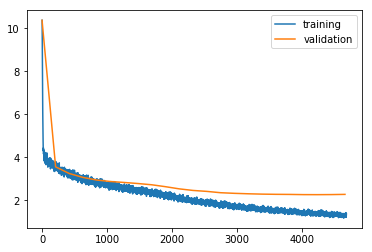

In [53]:
plot_train_chart(tr_val_loss_df)

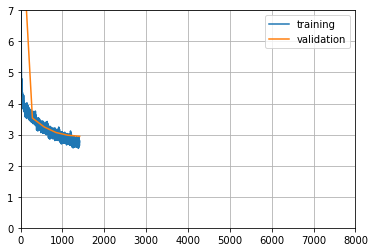

In [49]:
new_df = tr_val_loss_df.reset_index()
plt.plot(new_df.tr_loss.dropna(), label='training')
plt.plot(new_df.val_loss.dropna(), label='validation')
plt.xlim((0, 8000))
plt.ylim((0,7))
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
#model saving
save_model(encoder, decoder)


In [ ]:
encoder, decoder = load_model('CNN_400_80_cont_checkpoint')

In [217]:
len(input_train[::90]), len(input_val[::10])

(200, 200)

In [60]:
# analise of results
created_summaries_train, _ = predictions(encoder, decoder, input_train[::90], vocab_to_int, int_to_vocab)
created_summaries_val, _ = predictions(encoder, decoder, input_val[::10], vocab_to_int, int_to_vocab)

In [61]:
preprocessed_truncated_train = preprocessed_truncated.iloc[0:int(len(preprocessed_truncated)*0.9),:]
preprocessed_truncated_val = preprocessed_truncated.iloc[int(len(preprocessed_truncated)*0.9):,:]

In [62]:
len(input_train), len(preprocessed_truncated_train)

(18000, 18000)

                            	Train 	Validation
Number of summaries created:	200 	200        
Main ROUGE metrics:
Overall average:            	31.00 	25.63
Standard deviation:         	11.27 	10.06
Number of scores = 100:     	0 	0
Number of scores = 0:       	0 	2

Training summaries, highest and lowest ROUGE scores:

SUMMARY with highest score (ROUGE = 66.67)

REFERENCE SUMMARY
peter cammarano iii was hoboken youngest mayor . he was arrested after just
three weeks in office . cammarano pleaded guilty in april to conspiracy and
extortion . 

HYPOTHESIS SUMMARY
peter cammarano iii was hoboken youngest mayor . cammarano iii was hoboken
youngest mayor . cammarano pleaded guilty to conspiracy and extortion . 

SUMMARY with lowest score (ROUGE = 3.33)

REFERENCE SUMMARY
eeoc claims outdoors retailer discriminated against black , hispanic job
applicants . lawsuit also claims managers retaliated against people opposed to
practices . bass pro shops denies allegations and says it is determined 

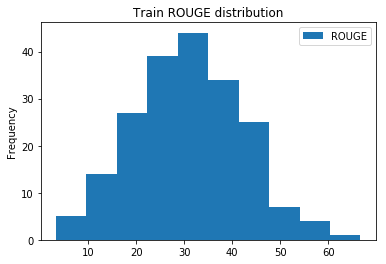

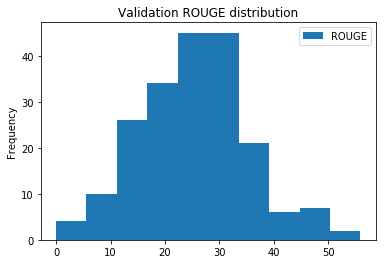

In [63]:
scores_df_train, scores_df_val =  predictions_analysis(created_summaries_train, 
                                                        preprocessed_truncated_train[::90], 
                                                        created_summaries_val, 
                                                        preprocessed_truncated_val[::10])   

In [64]:
import collections
counter=collections.Counter(created_summaries_val)
print(counter)
print(counter.values())
print('unique values: ', len(counter.values()))
print(counter.most_common(10))
for i in counter.keys():
  nice_print(i)


Counter({'the defendants are accused of using public money to pay lawmakers . the defendants are accused of using public money to pay lawmakers . the trial is expected to last a month and could the government party .': 1, '[UNK] black lights will be used in gallery to study on . starbucks is to use the and debris they leave . the chain says it is like western , the ceo of marketing management says .': 1, 'the ftc announced the new deal with at&t for iphone 5s , the lawsuit says . apple and at&t are a patent of iphone .': 1, 'the uk navy says it is carrying weapons to syria . the ship is currently out the north coast of scotland . the ship is currently out the north coast of scotland .': 1, 'us officials say it is not to be the investigation into possible oil . the white house has requested more than billion to fund the war in fiscal year 2010 . the us government has spent more than billion on the war in 2009 .': 1, 'the cuban government says it will not have its own brand line . the br

In [65]:
import collections
counter=collections.Counter(created_summaries_train)
print(counter)
print(counter.values())
print('unique values: ', len(counter.values()))
print(counter.most_common(10))
for i in counter.keys():
  nice_print(i)

Counter({'raphael jacquelin wins spanish open in the world rankings . the spanish golfer was at the tournament . the briton first prize . spaniard ignacio lopez and juan nestor .': 1, 'asteroid passes within 38,000 miles of earth on monday . scientists say it is nothing to know about asteroid . asteroid was discovered in the early early days , but it is too .': 1, 'police arrest a pakistani teenager who arrested him in karachi after an arrest . police arrested a pakistani teenager in karachi after an arrest warrant . police say he was ambushed by gunmen in karachi .': 1, 'victor solis son says he was arrested in the case . he was arrested in virginia , california , in connection with the case . he is accused of killing manuel rodriguez , a friend with the official .': 1, 'the us have been a great amount of trust in hillary clinton effectively to strengthen , the middle class . the us have seen the senate congress to consider transition . the senate congress would veto position to be de

# Corpus analysis: distribution of number of tokens

In [ ]:
N_EXAMPLES = 100000
ARTICLE_MIN_SENTENCES = 1
ARTICLE_MAX_SENTENCES = 400
SUMMARY_MIN_SENTENCES = 1
SUMMARY_MAX_SENTENCES = 30
# split of mini dataset into training and validation
FRACTION_VALIDATION = 0.1
MAX_WORD_ARTICLES = 3000 #500
MAX_WORD_SUMMARIES = 200 #65
corpus = pd.read_pickle(PROJECT_PATH + CORPUS_FILE_NAME)
mini_dataset = extract_mini_dataset(corpus)

In [ ]:
len(corpus), len(mini_dataset)

(87901, 87901)

In [ ]:
preprocessed = preprocess_data(mini_dataset)

In [ ]:
preprocessed['summary_num_tokens'] = preprocessed['summary'].apply(lambda x: len(x.split()))

In [ ]:
preprocessed['article_num_tokens'] = preprocessed['article'].apply(lambda x: len(x.split()))

In [ ]:
preprocessed.head()

,article,summary,summary_num_tokens,article_num_tokens
0,north korea fired 30 short-range rockets into ...,the rockets have an estimated range of 37 mile...,40,141
1,"in summer 2010 , big sky high school graduate ...","behind the scenes , rugby serves an american p...",39,1637
2,on the eve of the nobel peace prize award cere...,cnn.com is currently blocked in mainland china...,41,675
3,mexican marines have captured an alleged top l...,"two suspected accomplices were also arrested ,...",56,270
4,police forensic scientists involved in the ama...,court-appointed forensic experts testify durin...,56,716


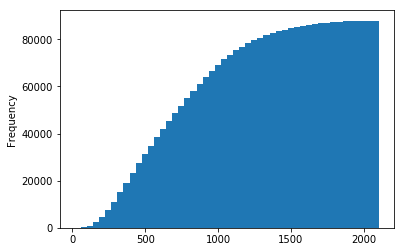

In [ ]:
preprocessed['article_num_tokens'].plot.hist( bins =50, cumulative=True)

In [ ]:
for num_tokens in range(1,1200,100):
  total_articles = preprocessed.loc[preprocessed['article_num_tokens']<num_tokens, 'article'].count()
  print('with {} tokens, {} articles, {:.2f}x'.format(num_tokens, total_articles, total_articles/num_tokens))

with 1 tokens, 0 articles, 0.00x
with 101 tokens, 200 articles, 1.98x
with 201 tokens, 3178 articles, 15.81x
with 301 tokens, 10317 articles, 34.28x
with 401 tokens, 19896 articles, 49.62x
with 501 tokens, 29612 articles, 59.11x
with 601 tokens, 38415 articles, 63.92x
with 701 tokens, 46476 articles, 66.30x
with 801 tokens, 54283 articles, 67.77x
with 901 tokens, 61537 articles, 68.30x
with 1001 tokens, 68170 articles, 68.10x
with 1101 tokens, 73366 articles, 66.64x


In [ ]:
15576/350

44.502857142857145

# Clean corpus dataset

In [ ]:
corpus = pd.read_pickle(PROJECT_PATH + CORPUS_FILE_NAME)

In [ ]:
corpus[['article','summary']].describe()

,article,summary
count,91871,91871
unique,88838,88141
top,"-- Esra'a al Shafei, a recent university gra...",This page includes the show Transcript and the...
freq,3,83


In [ ]:
corpus = corpus.loc[corpus['summary'].str.find('daily transcript')<0]

In [ ]:
corpus = corpus.loc[corpus['summary'].str.find('Transcript')<0]

In [ ]:
corpus = corpus.loc[corpus['summary'].str.find('Newsquiz')<0]

In [ ]:
corpus = corpus.loc[corpus['article'].str.find('(CNN Student News)')<0]

In [ ]:
corpus = corpus.loc[corpus['article'].str.find('Rick Steves')<0]

In [ ]:
corpus.shape

(91171, 8)

In [ ]:
corpus.drop_duplicates(inplace = True)

In [ ]:
corpus.drop_duplicates(subset = 'summary', inplace = True)

In [ ]:
corpus.drop_duplicates(subset = 'article', inplace = True)

In [ ]:
corpus.shape

(87901, 8)

In [ ]:
corpus[['article','summary']].describe()

,article,summary
count,87901,87901
unique,87901,87901
top,It's the end of the day in rural southwest Wis...,Travel nightmare comes true for American Stace...
freq,1,1


In [ ]:
corpus.to_pickle(PROJECT_PATH + CORPUS_FILE_NAME)